In [11]:
import numpy as np

import pandas as pd

import pymc3 as pm

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from modules.stats import GLMMPerformance

In [12]:
def sns_styleset():
    sns.set(context='paper', style='ticks')
    matplotlib.rcParams['figure.dpi']        = 300
    matplotlib.rcParams['axes.linewidth']    = .75
    matplotlib.rcParams['xtick.major.width'] = .75
    matplotlib.rcParams['ytick.major.width'] = .75
    matplotlib.rcParams['xtick.major.size']  = 3
    matplotlib.rcParams['ytick.major.size']  = 3
    matplotlib.rcParams['xtick.minor.size']  = 2
    matplotlib.rcParams['ytick.minor.size']  = 2
    matplotlib.rcParams['font.size']         = 9
    matplotlib.rcParams['axes.titlesize']    = 9
    matplotlib.rcParams['axes.labelsize']    = 9
    matplotlib.rcParams['legend.fontsize']   = 9
    matplotlib.rcParams['xtick.labelsize']   = 9
    matplotlib.rcParams['ytick.labelsize']   = 9
    
sns_styleset()

In [16]:
TUNERS_REMAP = {
    'rs': 'Random Search',
    'gp': 'Gaussian Process',
    'hb': 'HyperBand'
    
}
SOURCE_REMAP = {
    'mn_v': 'Vanilla \n MNIST',
    'mn_b': 'Back \n MNIST',
    'mn_r': 'Rotated \n MNIST',
    'mn_rb': 'RotBack \n MNIST',
}
METRIC_REMAP = {
    'acc': 'Accuracy',
    'f1': 'F1 Score',
    'precision': 'Precision',
    'recall': 'Recall',
    'time': 'Execution Time',
    'n_conf': 'Explored Configurations'
}

df = pd.read_csv('results\\tables\\models_results.csv')
tuners_df = []
for source in df['source'].unique():
    
    tuners_df.append(
        pd.read_csv(f'results\\tables\\tuners_results_{source}.csv')
    )
tuners_df = pd.concat(tuners_df)
df = df.merge(tuners_df, how='inner', on=['tuner', 'source'])


df['tuner'] = df['tuner'].map(TUNERS_REMAP)
df['source'] = df['source'].map(SOURCE_REMAP)

melted = pd.melt(df, id_vars=['tuner', 'source'], var_name='metric')
melted['metric'] = melted['metric'].map(METRIC_REMAP)
melted=melted.rename(columns={'tuner': 'Tuner', 'source': 'Source'})

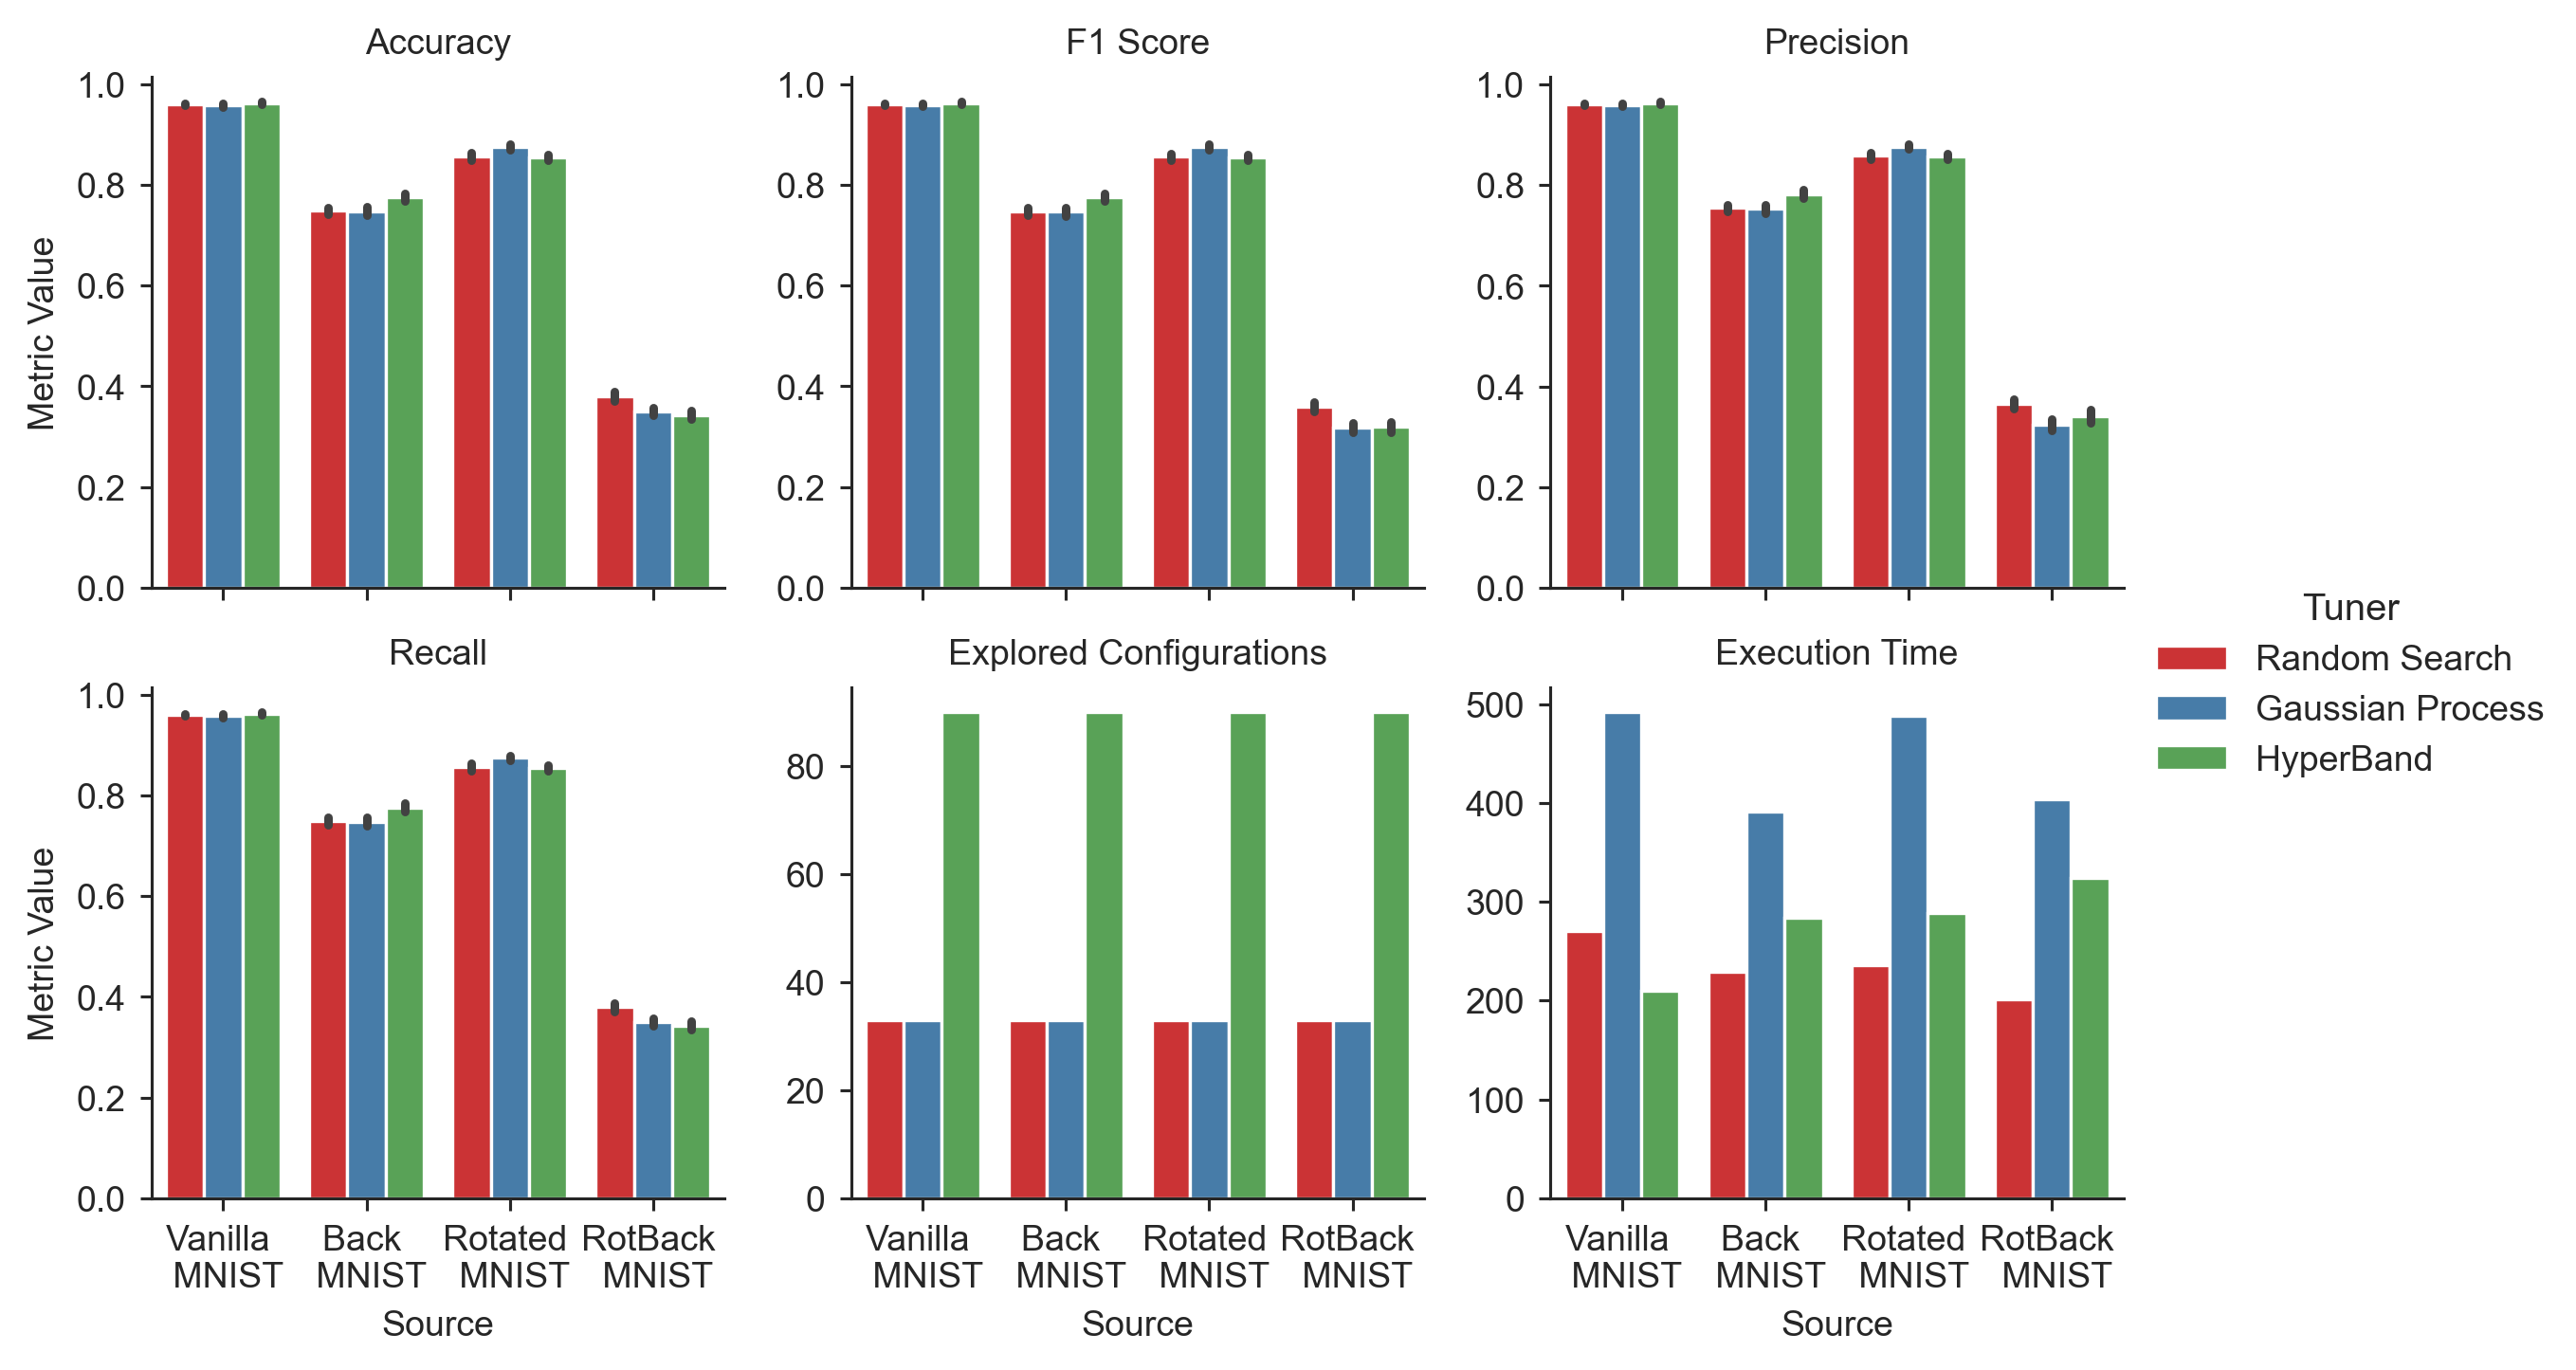

In [20]:
box_plots = sns.catplot(
    x='Source', 
    y='value', 
    col='metric',
    kind='bar',
    data=melted,
    col_wrap=3,
    height=2.5,
    sharey=False,
    sharex=True,
    hue='Tuner',
    palette='Set1'
)
box_plots.set_titles('{col_name}')
box_plots.set_ylabels('Metric Value')
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('results\\figures\\tuners_perfromance.png')
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Tuner, Context, hyper_sigma, hyper_normal]


Sampling 4 chains for 2_000 tune and 3_000 draw iterations (8_000 + 12_000 draws total) took 250 seconds.
The number of effective samples is smaller than 25% for some parameters.


Accuracy
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
Tuner[0]  0.150  0.069   0.021    0.283      0.002    0.001    1839.0  1839.0   
Tuner[1]  0.147  0.069   0.016    0.280      0.002    0.001    1839.0  1839.0   
Tuner[2]  0.149  0.069   0.020    0.283      0.002    0.001    1844.0  1844.0   

          ess_bulk  ess_tail  r_hat  
Tuner[0]    1847.0    2172.0    1.0  
Tuner[1]    1846.0    2142.0    1.0  
Tuner[2]    1849.0    2143.0    1.0  


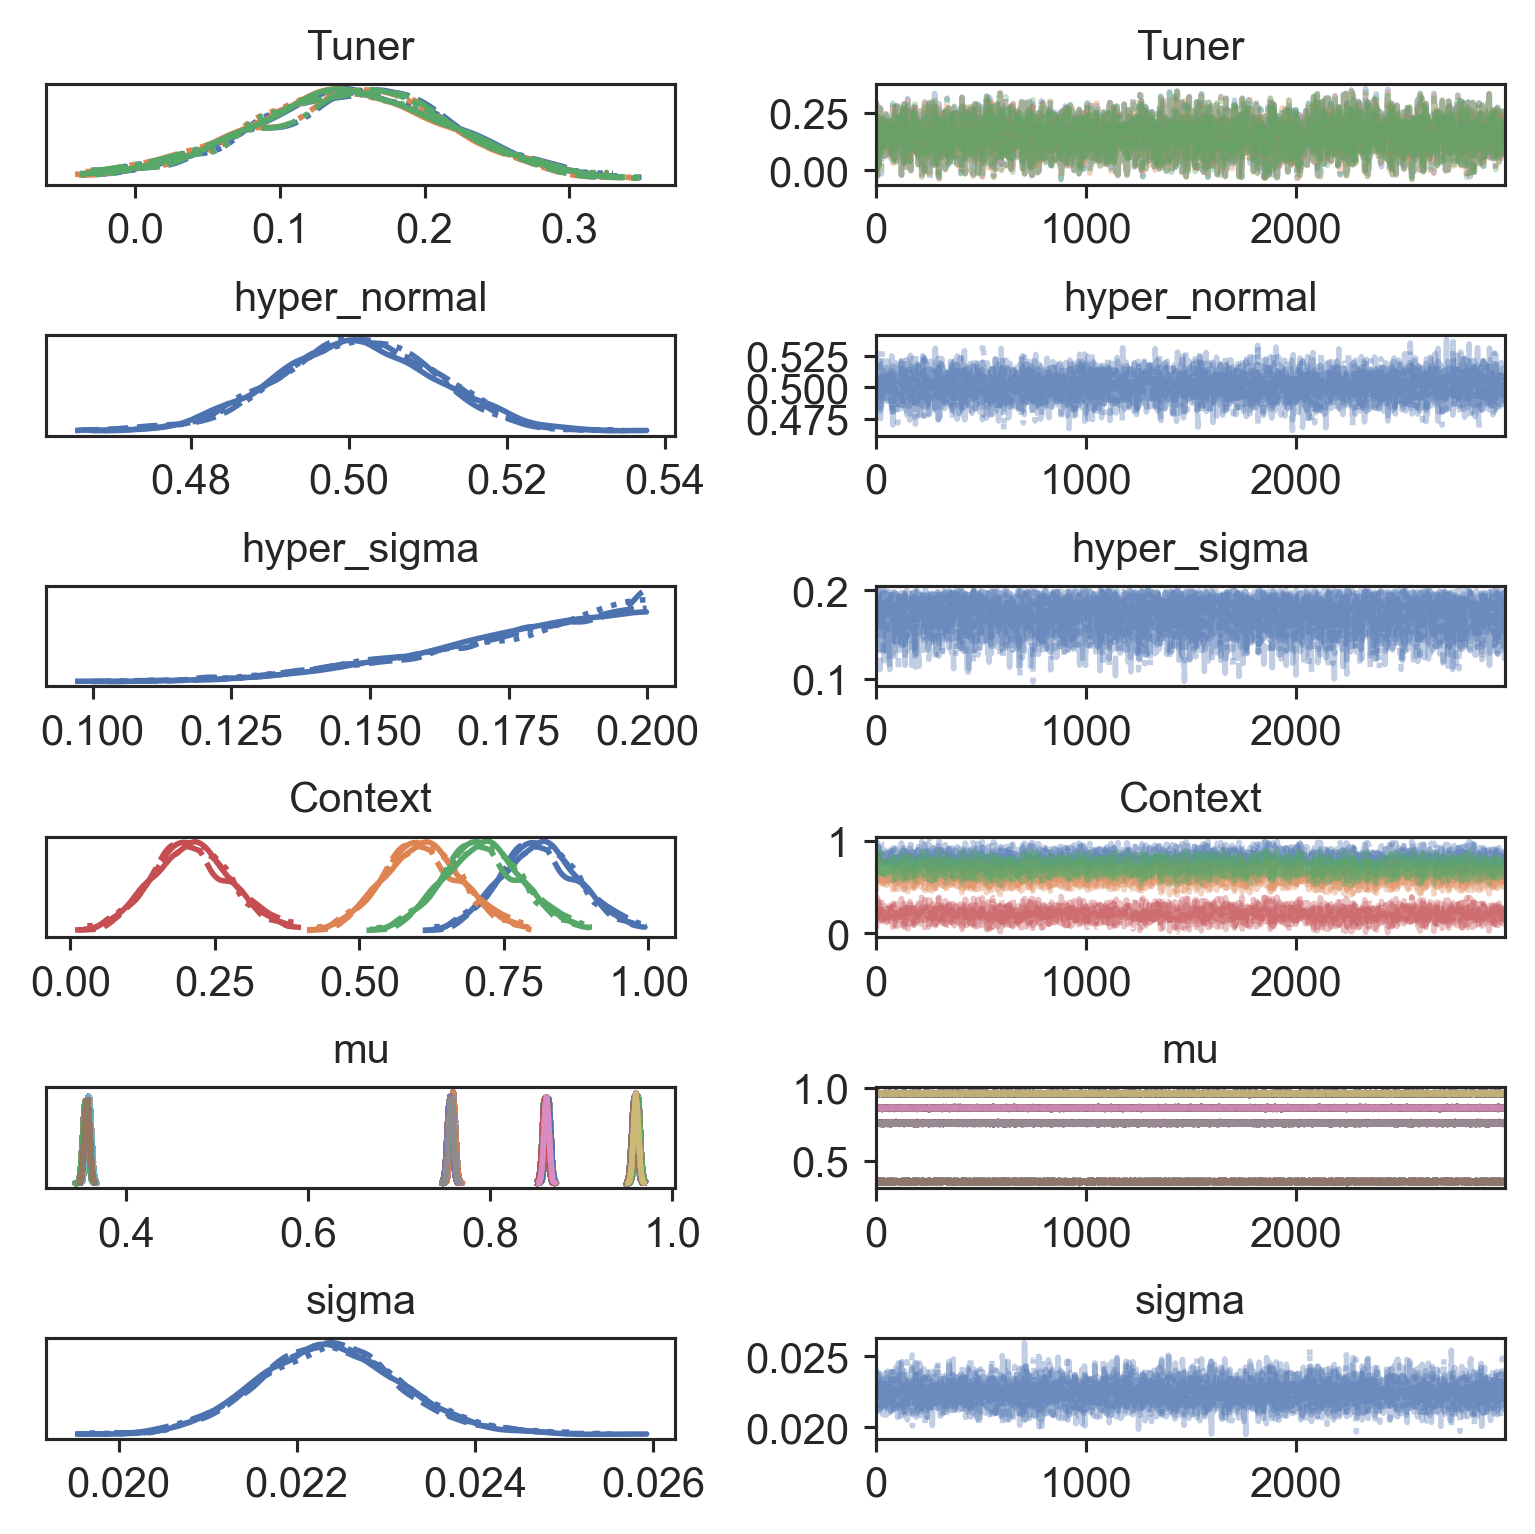

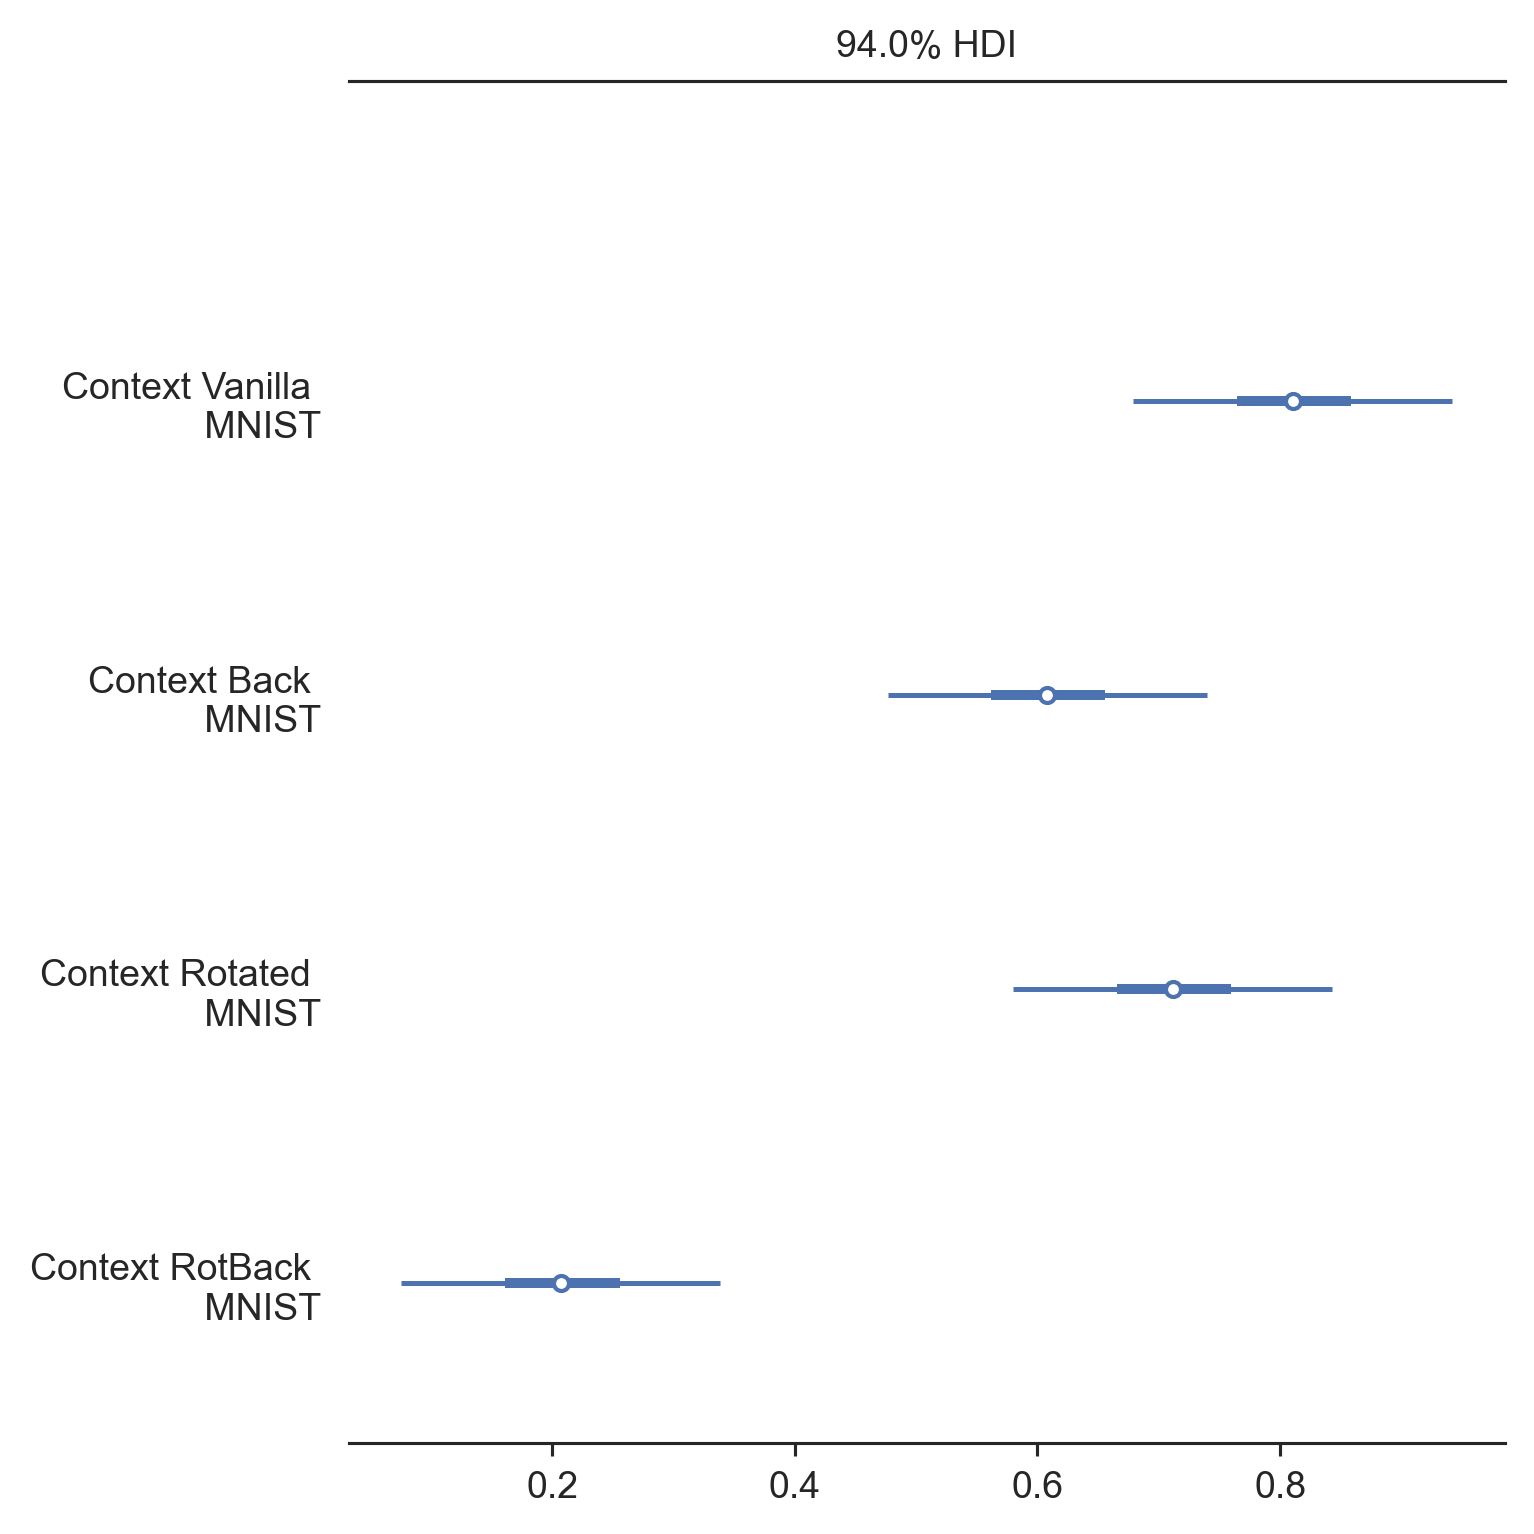

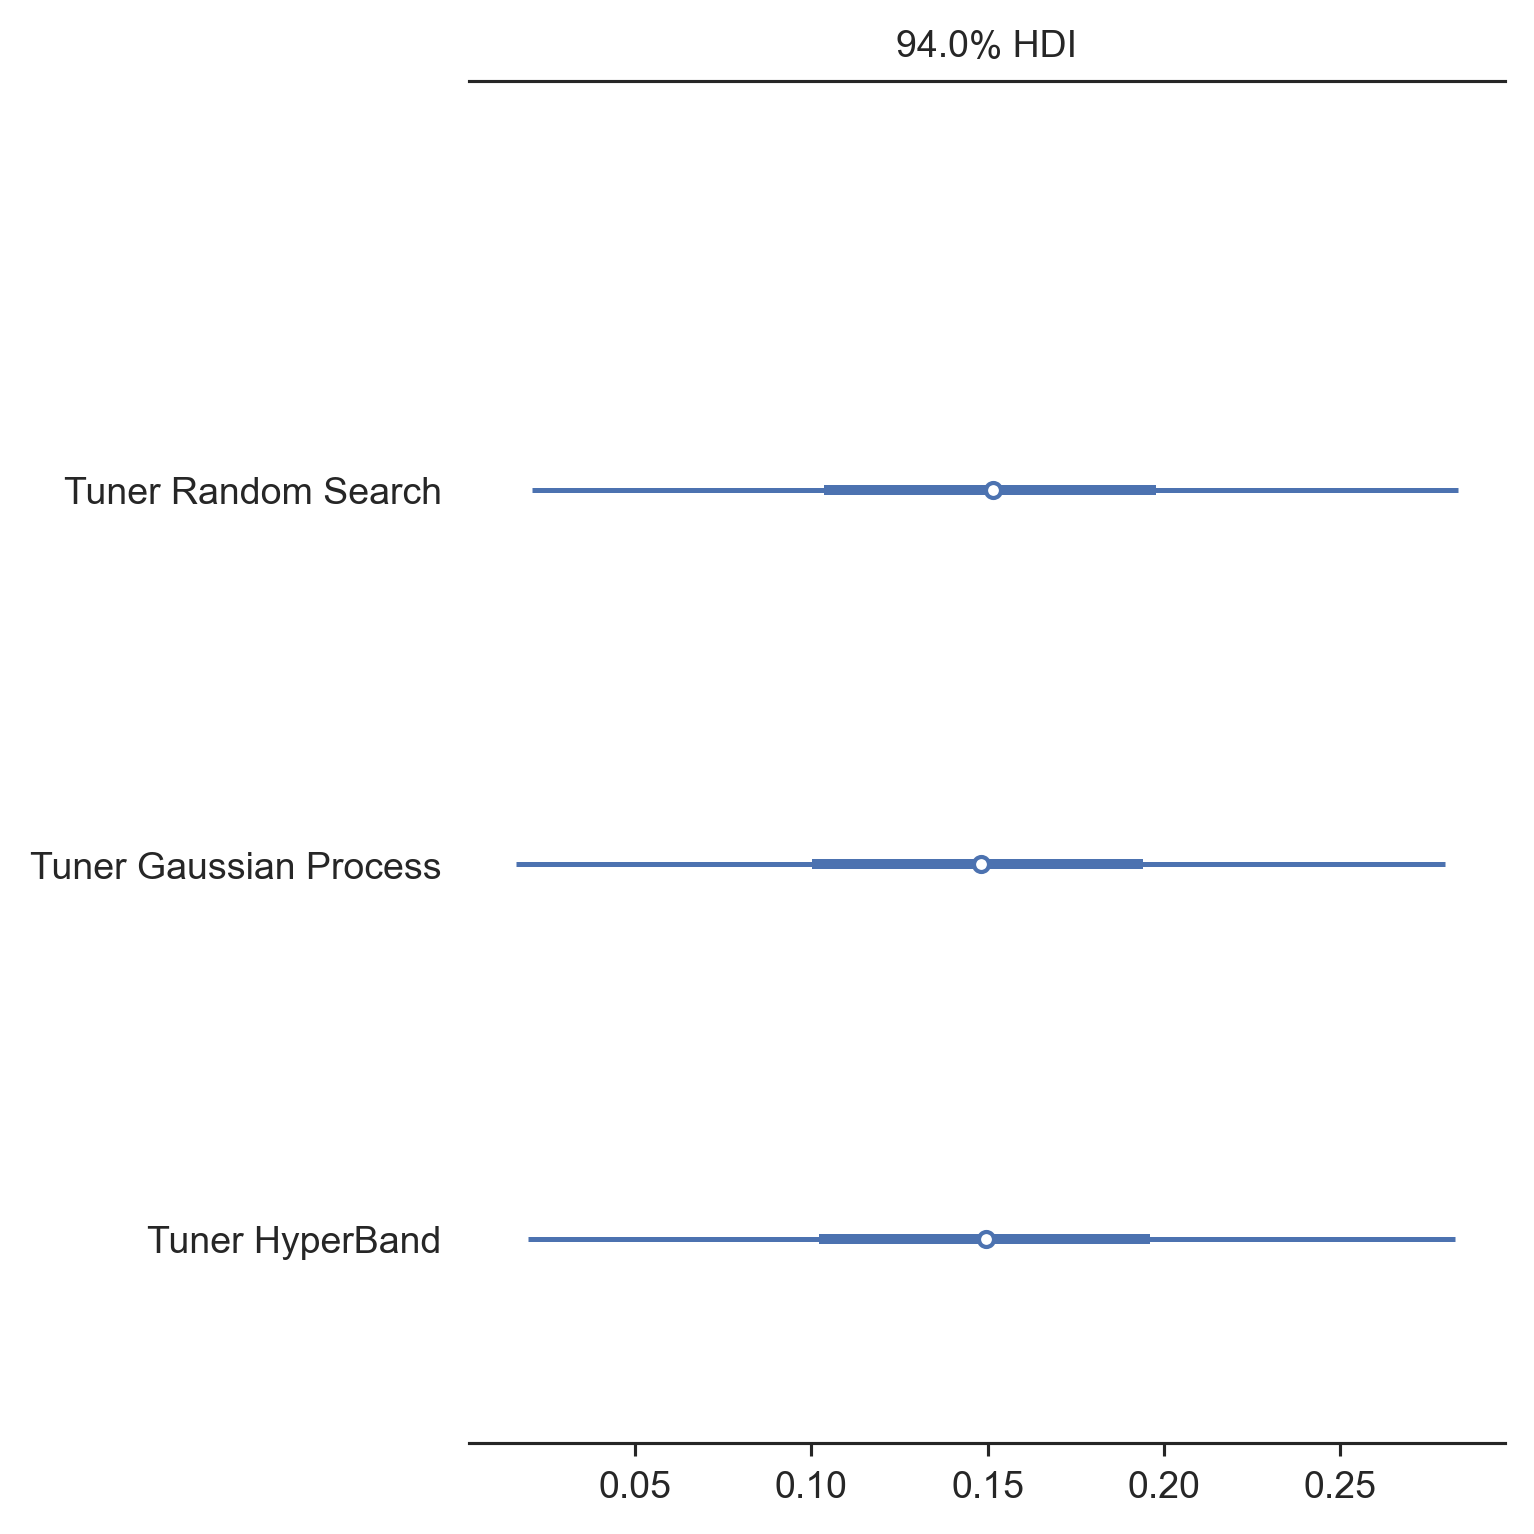

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Tuner, Context, hyper_sigma, hyper_normal]


In [ ]:
analyzer = GLMMPerformance(
    df=melted, 
    tuners_column='Tuner', 
    contexts_column='Source', 
    targets_column='metric'
)
analyzer.analyze(
    targets=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    draws=3000,
    tune=2000,
    target_accept=0.9
)